# Optimization with Surrogate Modeling

This notebook supplements SIMT ITS Analytics Projects lecture on Prescriptive Analytics Case Studies Overview by [Mansur M. Arief](https://mansurarief.github.io/).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/analytics-project-simt-its/analytics-project-simt-its.github.io/blob/main/notebooks/zoopt_with_surrogate_modeling.ipynb)

We will use `pycaret` to compare machine learning models quickly. This presumes that you have done your project in Part 1 of the course exploring each model on your own.

The dataset used here is the `energy` dataset, that contains properties describing a house (surface area, height, window area, etc). The goal is to estimate (regress) its heat or cooling energy load.

In [1]:
%pip install pycaret
%pip install mlflow
%pip install shap
%pip install zoopt

## Dataset

In [2]:
from pycaret.datasets import get_data
df = get_data('energy')

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
df.columns
# Relative Compactness is the ratio of the area of the walls to the area of the walls if they were flat
# Surface Area is the total surface area of the building
# Wall Area is the total wall area of the building
# Roof Area is the total roof area of the building
# Glazing Area is the area of the windows in the building

Index(['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
       'Overall Height', 'Orientation', 'Glazing Area',
       'Glazing Area Distribution', 'Heating Load', 'Cooling Load'],
      dtype='object')

## Training models

In [4]:
from pycaret.regression import *

energy_reg1 = setup(df,
                    ignore_features = ['Heating Load'],
                    target = 'Cooling Load',
                    session_id=2024,
                    log_experiment=False,
                    experiment_name='energy_regression1')

,Description,Value
0,Session id,2024
1,Target,Cooling Load
2,Target type,Regression
3,Original data shape,"(768, 10)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Ignore features,1
8,Numeric features,8
9,Preprocess,True


We will use cross validation with $k=5$ fold.

In [5]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6389,1.1489,1.0491,0.9870,0.0334,0.0238,0.0820
lightgbm,Light Gradient Boosting Machine,0.8873,1.7100,1.3070,0.9807,0.0413,0.0328,1.2380
gbr,Gradient Boosting Regressor,1.0391,2.3767,1.5382,0.9734,0.0472,0.0375,0.1020
rf,Random Forest Regressor,1.0569,3.0333,1.7351,0.9661,0.0527,0.0369,0.2300
et,Extra Trees Regressor,1.0586,3.4956,1.8625,0.9608,0.0561,0.0367,0.1840
dt,Decision Tree Regressor,1.1719,4.3431,2.0757,0.9514,0.0641,0.0417,0.0300
knn,K Neighbors Regressor,1.6732,4.8552,2.1883,0.9454,0.0835,0.0699,0.0480
ada,AdaBoost Regressor,1.7986,5.6480,2.3697,0.9366,0.0805,0.0697,0.0600
lr,Linear Regression,2.2554,10.0908,3.1656,0.8867,0.1111,0.0905,1.0680
br,Bayesian Ridge,2.2873,10.2643,3.1924,0.8849,0.1141,0.0939,0.0640


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Let's choose `xgboost` as our main model.

In [6]:
model = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5717,0.6607,0.8128,0.9935,0.0260,0.0208
1,0.4672,0.4311,0.6566,0.9949,0.0231,0.0184
2,0.7359,1.9448,1.3946,0.9759,0.0420,0.0272
3,0.4927,0.4909,0.7006,0.9931,0.0240,0.0189
4,0.7712,2.2455,1.4985,0.9784,0.0402,0.0254
5,0.4773,0.5715,0.7560,0.9933,0.0256,0.0191
6,0.6353,0.7986,0.8936,0.9897,0.0314,0.0245
7,0.7764,1.9709,1.4039,0.9804,0.0398,0.0271
8,0.4646,0.4741,0.6886,0.9950,0.0253,0.0196


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

We can study the model residuals, error, feature importance, etc.

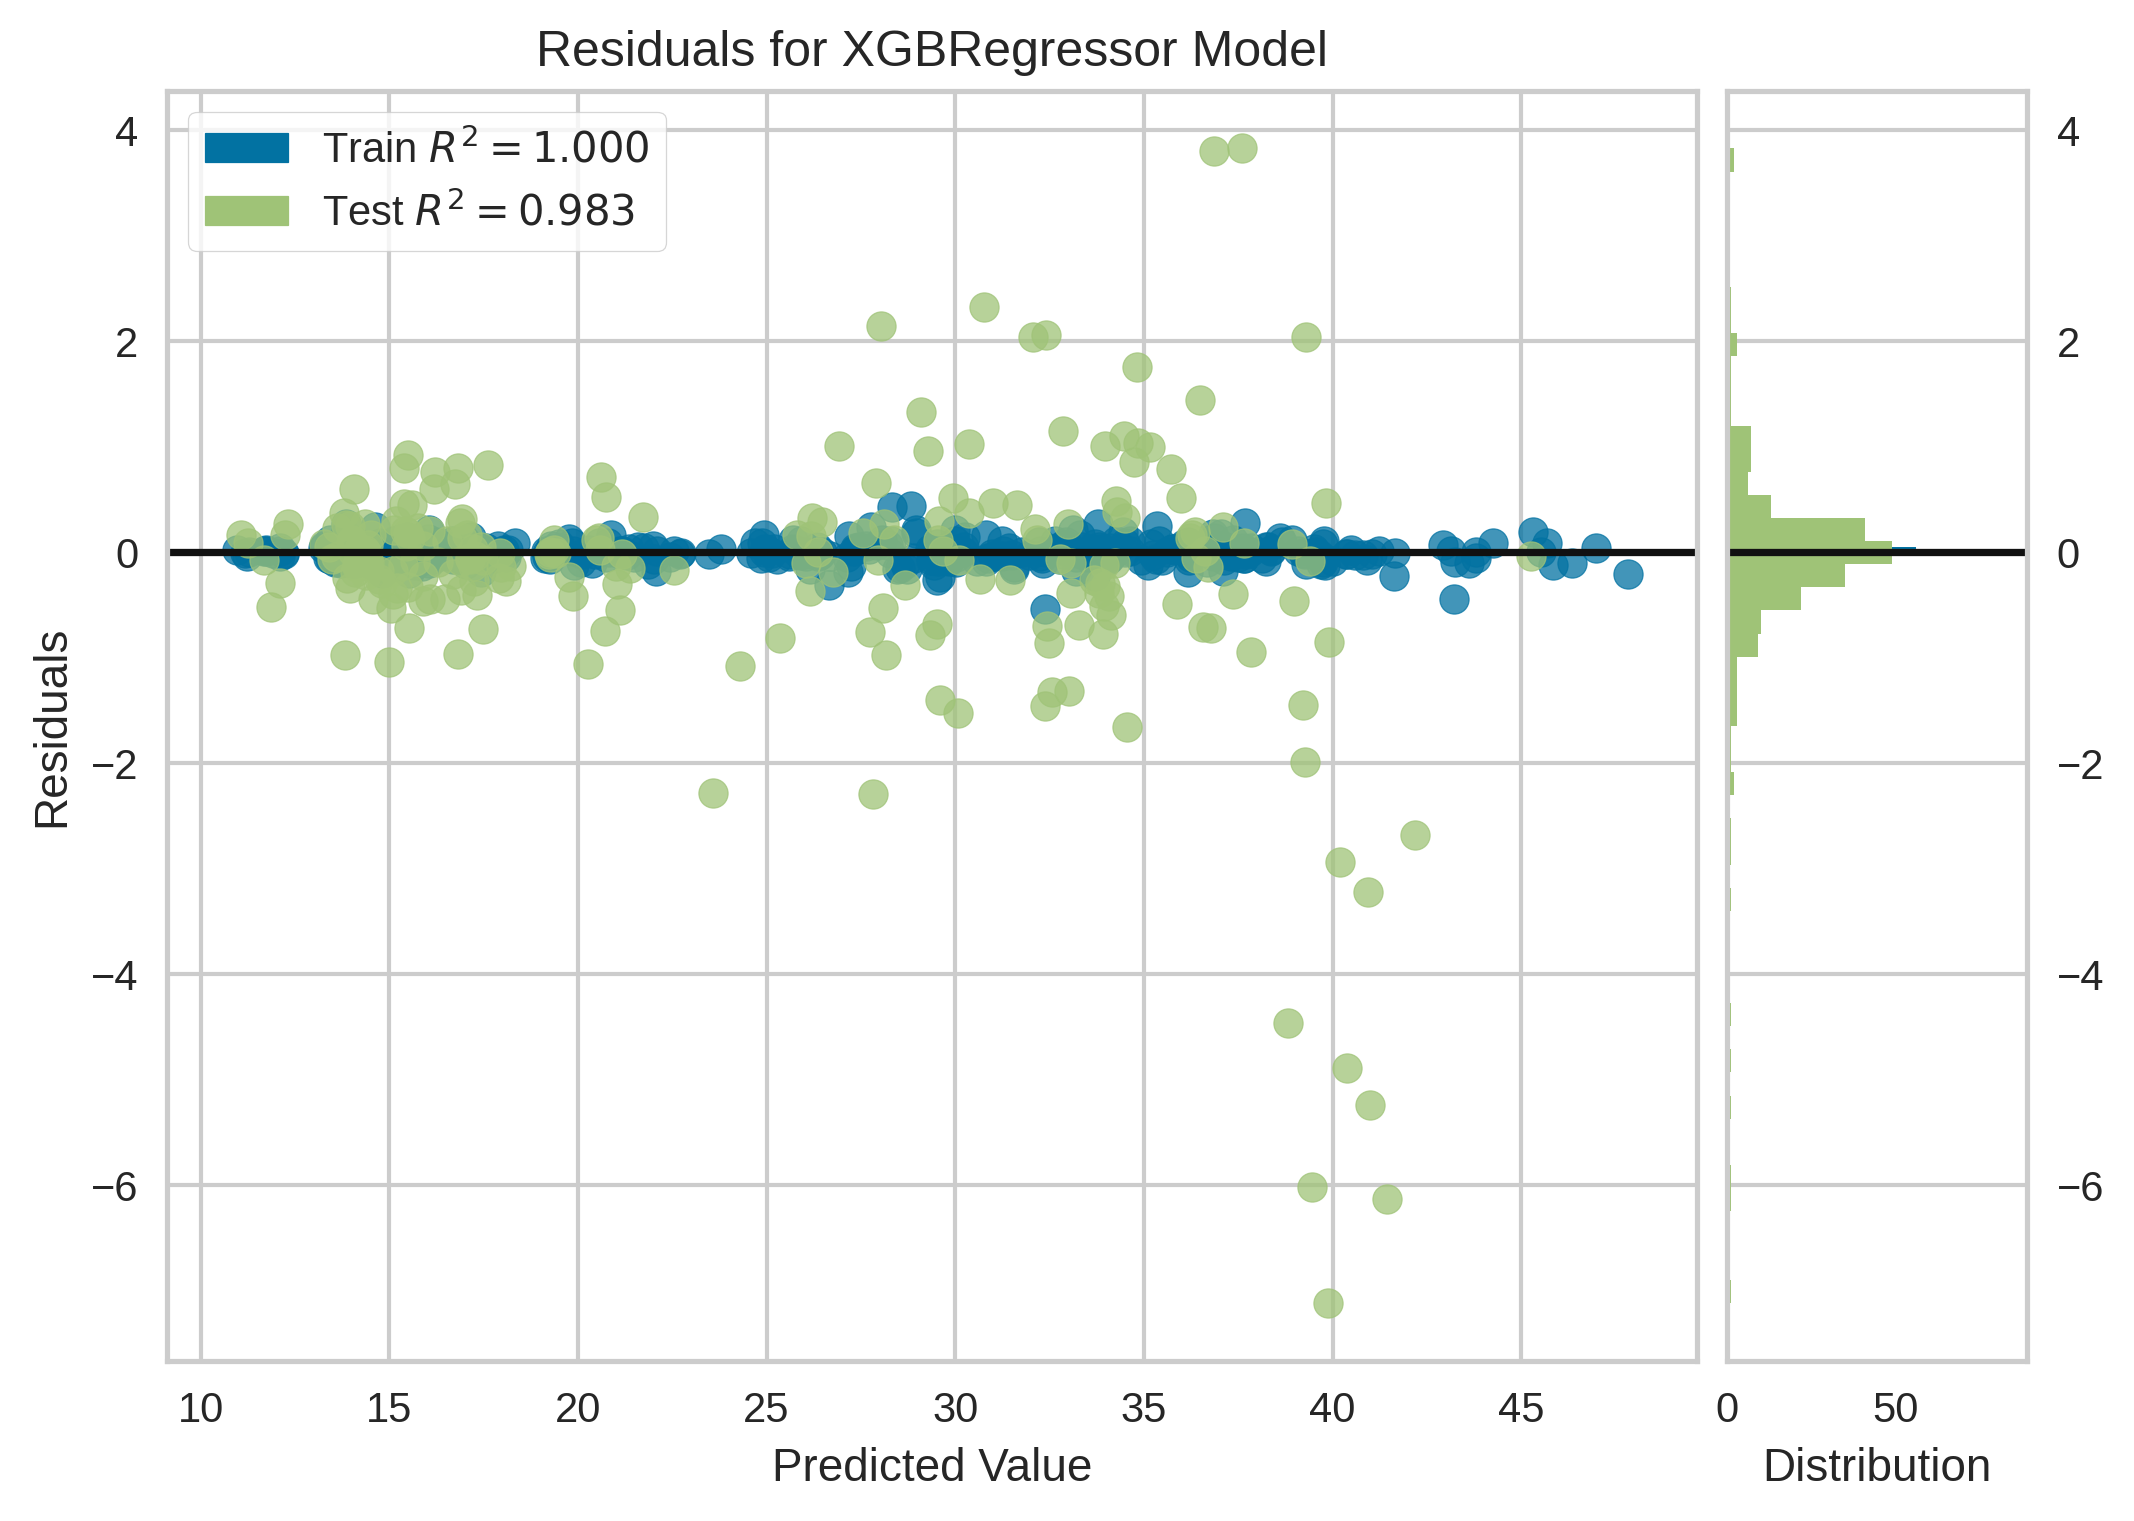

In [7]:
plot_model(model, scale=3)

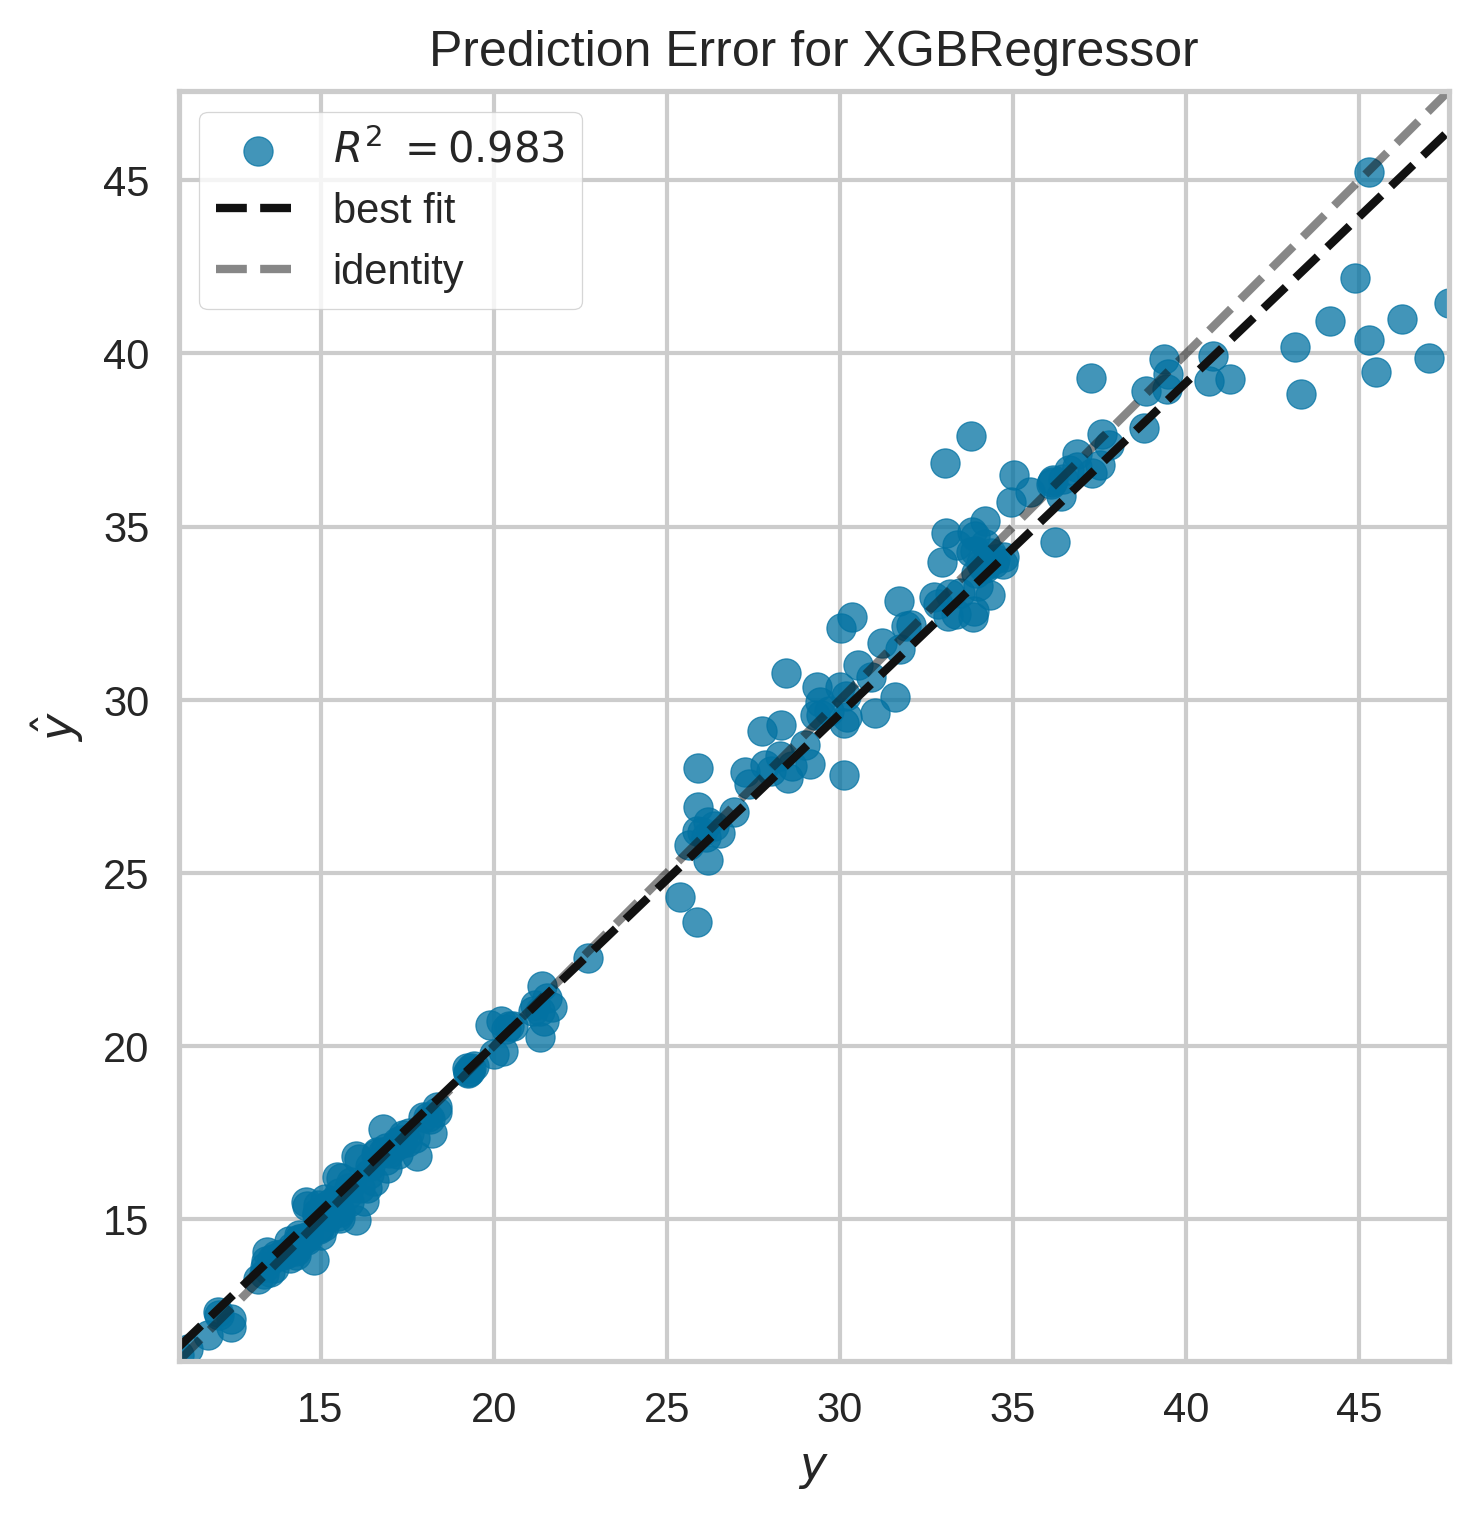

In [8]:
plot_model(model, plot="error", scale=3)

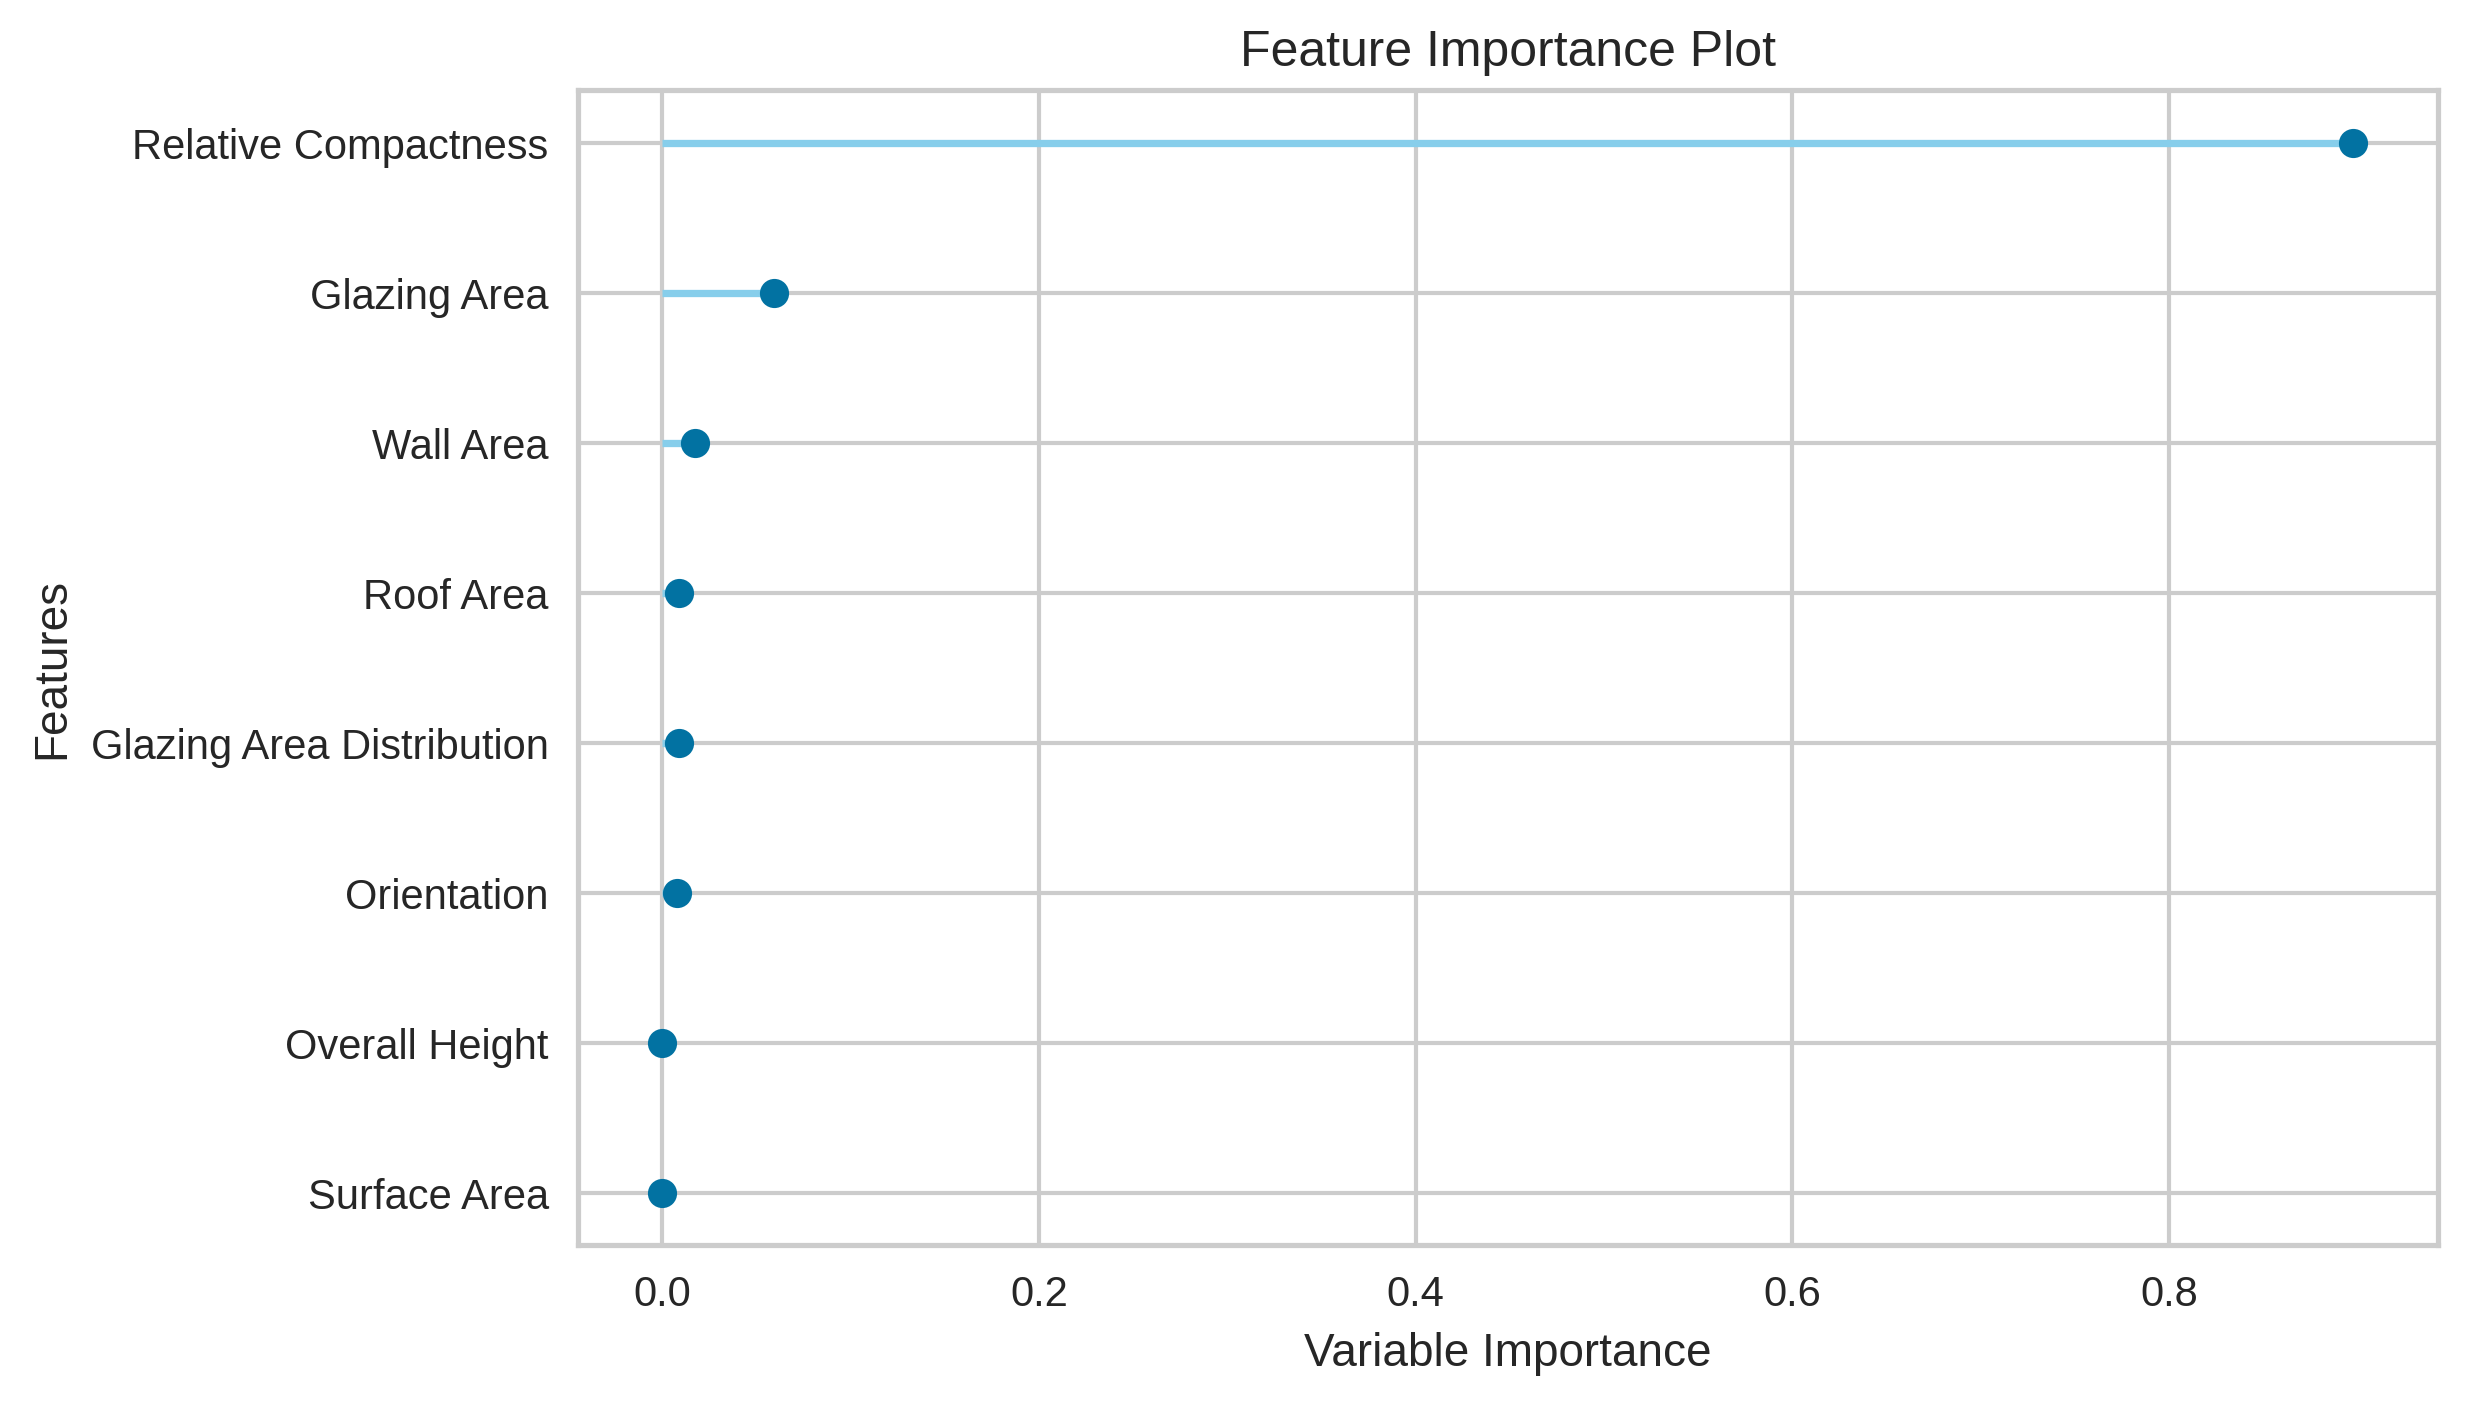

In [9]:
plot_model(model, plot = 'feature', scale=3)

We can also evaluate many other aspects of the model. Feel free to play around here if you want.

In [10]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

We can see how the model perform on the holdout dataset.

In [11]:
pred_holdouts = predict_model(model)
pred_holdouts.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.6556,1.5229,1.2341,0.9834,0.0344,0.0231


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Cooling Load,prediction_label
286,0.62,808.5,367.5,220.50,3.5,4,0.10,5,13.990000,14.000792
710,0.66,759.5,318.5,220.50,3.5,4,0.40,4,18.360001,18.231325
13,0.82,612.5,318.5,147.00,7.0,3,0.00,0,21.459999,20.713896
296,0.86,588.0,294.0,147.00,7.0,2,0.25,1,33.980000,33.292915
290,0.98,514.5,294.0,110.25,7.0,4,0.25,1,29.280001,29.573301


## Optimization

Suppose now that we want to design an 'optimal' house that minimize the cooling load based. We will use the prediction model as our surrogate model.

### 2d problem
For this purpose, we have
- decision variables: relative compactness $x_1$ and glazing area $x_2$
- objective function: $f(x_1, x_2)$ =  XGBoostPrediction(relative_compactness=x_1, glazing_area=x_2, surface_area=800, wall_area=350, roof_area=200, ...)
- constraints: $0 \leq x_1 \leq 1$, $0 \leq x_2 \leq 1$


We can plot the objective function.

In [12]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.interpolate import griddata

# Define constant data point
data_point = {
    "Surface Area": 800, "Wall Area": 350, "Roof Area": 200, "Overall Height": 4,
    "Orientation": 2, "Glazing Area Distribution": 1
}

# Generate the ranges
relative_compactness = np.arange(0.01, 1.01, 0.02)
glazing_area = np.arange(0.01, 1.01, 0.02)

# Use product to create combinations
combinations = [
    {**data_point, "Relative Compactness": r, "Glazing Area": g}
    for r, g in product(relative_compactness, glazing_area)
]

# Create DataFrame
data = pd.DataFrame(combinations)
pred = predict_model(model, data=data)

# Prepare data for surface plot
X, Y = np.meshgrid(glazing_area, relative_compactness)
Z = griddata((data['Glazing Area'], data['Relative Compactness']), pred['prediction_label'], (X, Y), method='cubic')

# Plotting
fig = go.Figure(data=[go.Surface(z=Z, x=X[0], y=Y[:, 0], colorscale='jet')])
fig.update_layout(title='Predicted Cooling Load', autosize=True,
                  width=800, height=600,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
                      xaxis_title='Glazing Area',
                      yaxis_title='Relative Compactness',
                      zaxis_title='Prediction Label'
                  ))
fig.show()


Since our objective function is a predictive model (it is likely not differentiable, etc.). Therefore, let's use zero order optimization `zoopt`.

In [13]:
from zoopt import Dimension, ValueType, Dimension2, Objective, Parameter, Opt, ExpOpt

# Define dimensionality of the problem
dim_size = 2
dim = Dimension(dim_size, [[0, 1]]*dim_size, [True]*dim_size)

def get_prediction(r, g, model):
  data_point = {
        "Surface Area": 800,
        "Relative Compactness": r,
        "Glazing Area": g,
        "Wall Area": 350,
        "Roof Area": 200,
        "Overall Height": 4,
        "Orientation": 2,
        "Glazing Area Distribution": 1
    }
  data_df = pd.DataFrame([data_point])
  predicted_cooling_load = predict_model(model, data=data_df)
  out = predicted_cooling_load.iloc[0]['prediction_label']
  return out



Set up `zoopt` interface and our logger

In [14]:
best_val = 999999
log_path = "optimization_results.txt"
open(log_path, "w").close()

# Set up objective for zoopt
def objective_function(solution):
    global best_val
    x = solution.get_x()
    obj_val = get_prediction(x[0], x[1], model)
    if obj_val <= best_val:
      with open(log_path, "a") as file:
          file.write(f"{x[0]}, {x[1]}, {obj_val}\n")
          best_val = obj_val
    return obj_val

obj = Objective(func=objective_function, dim=dim)

# Set up param for solver
param = Parameter(budget=1000,
                  time_budget=60,
                  intermediate_result=True,
                  intermediate_freq=20,
                  exploration_rate=0.05,
                  seed=2024)


# Solve
solution = Opt.min(obj, param)

[zoopt] expected remaining running time: 00:01:00


[zoopt] budget 20, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 40, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 60, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 80, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 100, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 120, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 140, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 160, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 180, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 200, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 220, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 240, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 260, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] budget 280, fx result: 12.207902908325195
[zoopt] x: [0.12982963701113318, 0.043808563746864815]


[zoopt] time_budget runs out
[zoopt] x: [0.12982963701113318, 0.043808563746864815]
[zoopt] value: 12.207902908325195


This shows the best solution's objective value improvement over time

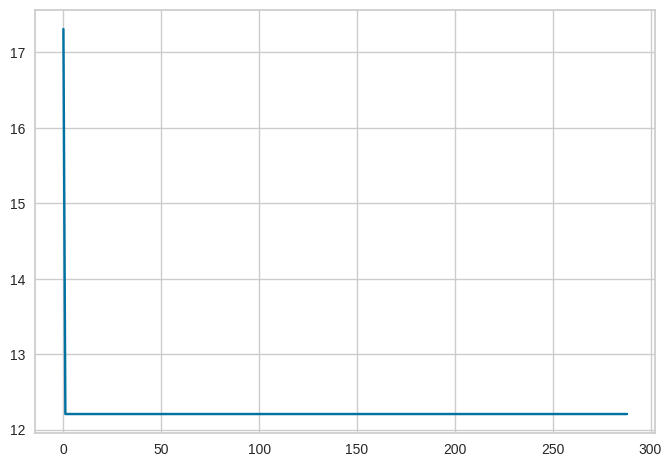

In [15]:
plt.plot(obj.get_history_bestsofar())

In [16]:
df_opt = pd.read_csv(log_path, header=None, names=[
    'Relative Compactness', 'Glazing Area', 'Approximated f(x)'])

fig = go.Figure(data=[go.Surface(z=Z, x=X[0], y=Y[:, 0], colorscale='jet', opacity=0.5)])
fig.add_trace(
    go.Scatter3d(
        x=df_opt['Glazing Area'],
        y=df_opt['Relative Compactness'],
        z=df_opt['Approximated f(x)'],
        mode='lines+markers',
        marker=dict(
            size=5,
            color='black',  # Color of the markers
        ),
        line=dict(width=10,
                  color='black'
        ),
        name='Optimization Points'
    )
)
fig.update_layout(title='Predicted Cooling Load', autosize=True,
                  width=800, height=600,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
                      xaxis_title='Glazing Area',
                      yaxis_title='Relative Compactness',
                      zaxis_title='Approximated f(x)'
                  ))
fig.show()

### 6d problem

Here, we have
- decision variables: surface area $x_1$ and relative compactness $x_2$, glazing area $x_3$, ...
- objective function: $f(x_1, x_2, x_3, x_4, x_5, x_6)$ =  XGBoostPrediction(surface_area=x_1, relative_compactness=x_2, glazing_area=x_3, ...)
- constraints: $500 \leq x_1 \leq 800$, $0 \leq x_2 \leq 1$, ...


Since we are in 6d, we cannot plot the objective. Let's solve it right away!

In [20]:
# Prepare variable and dimension
best_val = 999999
log_path = "optimization_results_6d.txt"
open(log_path, "w").close()

dim_size = 6
dim = Dimension2(
    [
        (ValueType.CONTINUOUS, [500, 800], 1),
        (ValueType.CONTINUOUS, [0, 1], 0.01),
        (ValueType.CONTINUOUS, [0, 1], 0.01),
        (ValueType.CONTINUOUS, [100, 300], 1),
        (ValueType.CONTINUOUS, [100, 430], 1),
        (ValueType.DISCRETE, [1, 2, 3, 4, 5]),
    ])


# Prepare objective function for zoopt
def get_prediction(s, c, g, w, r, h, model):
  data_point = {
        "Surface Area": s,
        "Relative Compactness": c,
        "Glazing Area": g,
        "Wall Area": w,
        "Roof Area": r,
        "Overall Height": h,
        "Orientation": 2,
        "Glazing Area Distribution": 1
    }
  data_df = pd.DataFrame([data_point])
  predicted_cooling_load = predict_model(model, data=data_df)
  out = predicted_cooling_load.iloc[0]['prediction_label']
  return out


def objective_function(solution):
    global best_val
    x = solution.get_x()
    obj_val = get_prediction(x[0], x[1], x[2], x[3], x[4], x[5], model)
    if obj_val <= best_val:
      best_val = obj_val
      with open(log_path, "a") as file:
          file.write(f"{x[0]}, {x[1]}, {x[2]}, {x[3]}, {x[4]}, {x[5]}, {obj_val}\n")

    return obj_val

# Define the Objective
obj = Objective(func=objective_function, dim=dim)
param = Parameter(budget=1000,
                  time_budget=60,
                  intermediate_result=True,
                  intermediate_freq=50,
                  exploration_rate=0.1,
                  seed=2023)

solution = Opt.min(obj, param)



[zoopt] expected remaining running time: 00:01:00


[zoopt] budget 50, fx result: 14.216777801513672
[zoopt] x: [524.0, 0.7, 0.19, 109.0, 348.0, 1]


[zoopt] budget 100, fx result: 14.216777801513672
[zoopt] x: [524.0, 0.7, 0.19, 109.0, 348.0, 1]


[zoopt] budget 150, fx result: 14.216777801513672
[zoopt] x: [524.0, 0.7, 0.19, 109.0, 348.0, 1]


[zoopt] budget 200, fx result: 14.216777801513672
[zoopt] x: [524.0, 0.7, 0.19, 109.0, 348.0, 1]


[zoopt] budget 250, fx result: 14.216777801513672
[zoopt] x: [524.0, 0.7, 0.19, 109.0, 348.0, 1]


[zoopt] time_budget runs out
[zoopt] x: [524.0, 0.7, 0.19, 109.0, 348.0, 1]
[zoopt] value: 14.216777801513672


In [21]:
df_opt = pd.read_csv('optimization_results_6d.txt', header=None, names=[
    'Surface Area', 'Relative Compactness', 'Glazing Area',
    'Wall Area', 'Roof Area', 'Overall Height', 'Approximated f(x)'
])

df_opt

,Surface Area,Relative Compactness,Glazing Area,Wall Area,Roof Area,Overall Height,Approximated f(x)
0,597.0,0.89,0.59,125.0,147.0,2,35.861168
1,676.0,0.70,0.19,109.0,168.0,2,14.216778
2,524.0,0.70,0.19,109.0,168.0,2,14.216778
3,524.0,0.70,0.19,109.0,168.0,1,14.216778
4,524.0,0.70,0.19,109.0,390.0,2,14.216778
5,524.0,0.70,0.19,109.0,248.0,2,14.216778
6,524.0,0.70,0.19,109.0,248.0,1,14.216778
7,524.0,0.70,0.19,109.0,229.0,2,14.216778
8,524.0,0.70,0.19,109.0,348.0,2,14.216778
9,524.0,0.70,0.19,109.0,348.0,1,14.216778


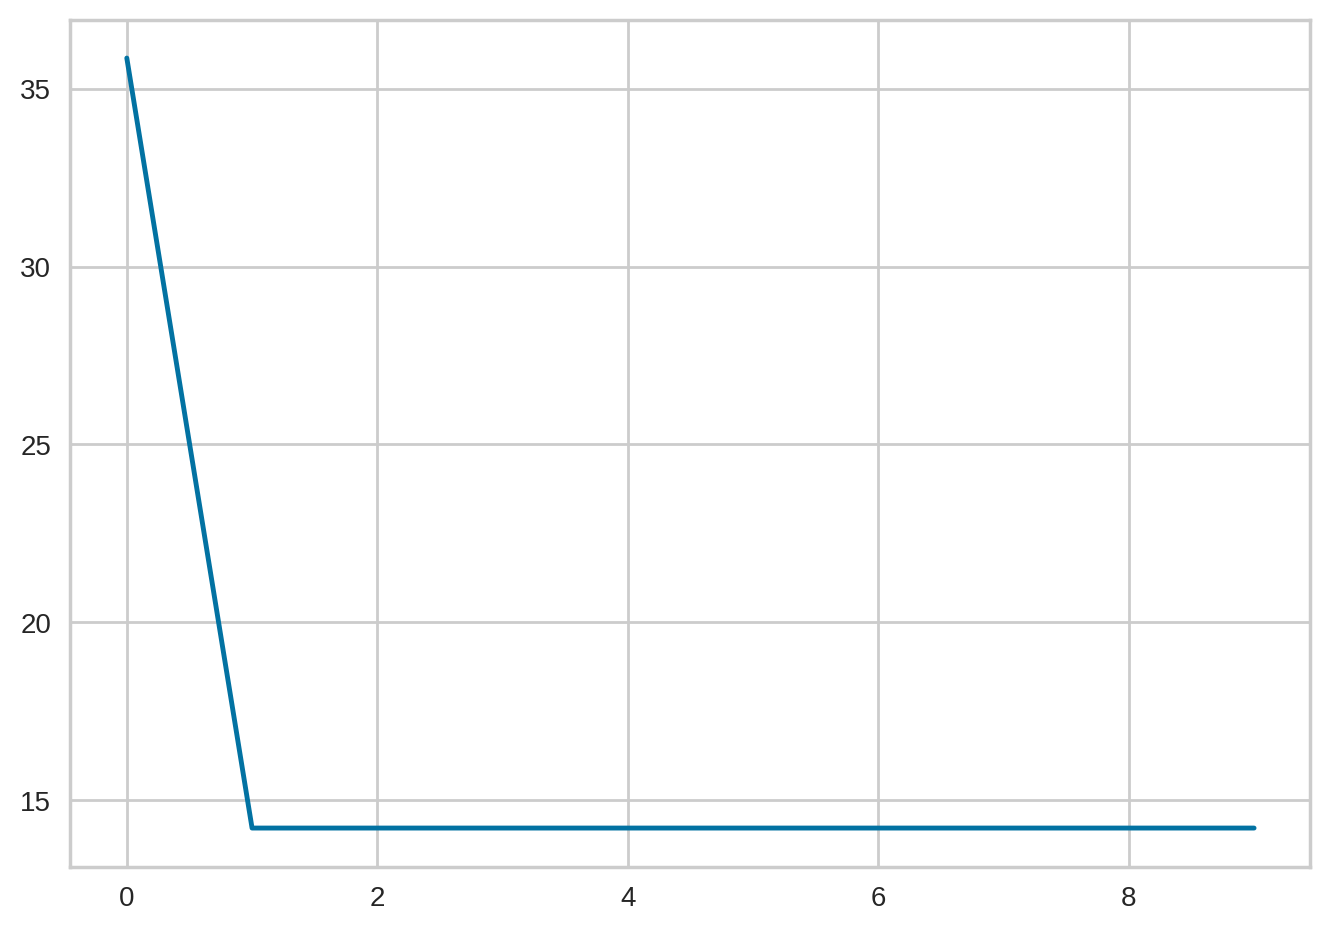

In [22]:
plt.figure(dpi=200)
plt.plot(df_opt["Approximated f(x)"])

### Remarks

- Since we are using a predictive function $\hat{f}(x)$ as our $f(x)$, the quality of the solution depends on how accurate $\hat{f}(x)$ is.
- In this case, we have many regions with flat $\hat{f}(x)$, which leads to many minima, and therefore our optimization algorithm may found just one of these optima point.
- In practice, you might want to keep collecting samples, especially around the optimal solution $x^*$ and use these to re-train $\hat{f}(x)$ to improve its accuracy over time.